In [24]:
import ot
import numpy as np
import torch
W = np.loadtxt("matrix.txt")
c = np.transpose(np.loadtxt("dists.txt"))

r=ot.bregman.barycenter(A=c, M=W, method='sinkhorn_log', reg=0.001, numItermax=100000, verbose=True)


    1|2.732827e-01|
   11|6.770497e-02|
   21|2.733905e-02|
   31|1.287558e-02|
   41|6.739471e-03|
   51|3.875796e-03|
   61|2.430982e-03|
   71|1.648359e-03|
   81|1.192880e-03|
   91|9.096382e-04|
  101|7.220435e-04|
  111|5.886949e-04|
  121|4.865645e-04|
  131|4.025445e-04|
  141|3.300683e-04|
  151|2.669182e-04|
  161|2.128871e-04|
  171|1.678811e-04|
  181|1.314316e-04|
  191|1.027354e-04|


FileNotFoundError: test.txt not found.

In [27]:
rtest = np.loadtxt("rtest.txt")
sum(ot.emd2(rtest, c[:, i], W) for i in range(6)), sum(ot.emd2(r, c[:, i], W) for i in range(6))

(0.019392439598832883, 0.04078886223790741)

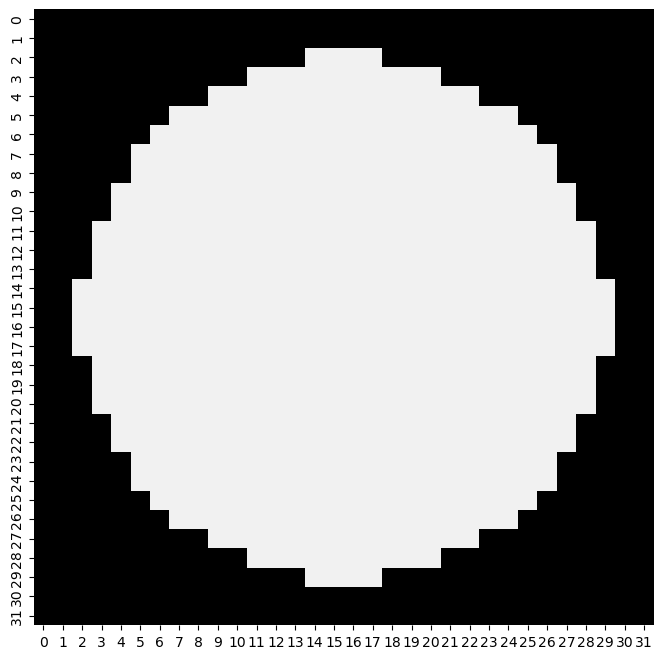

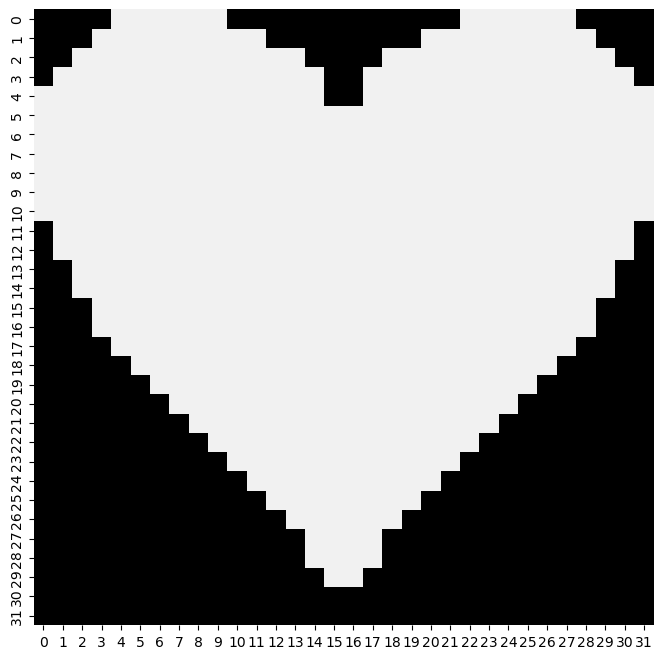

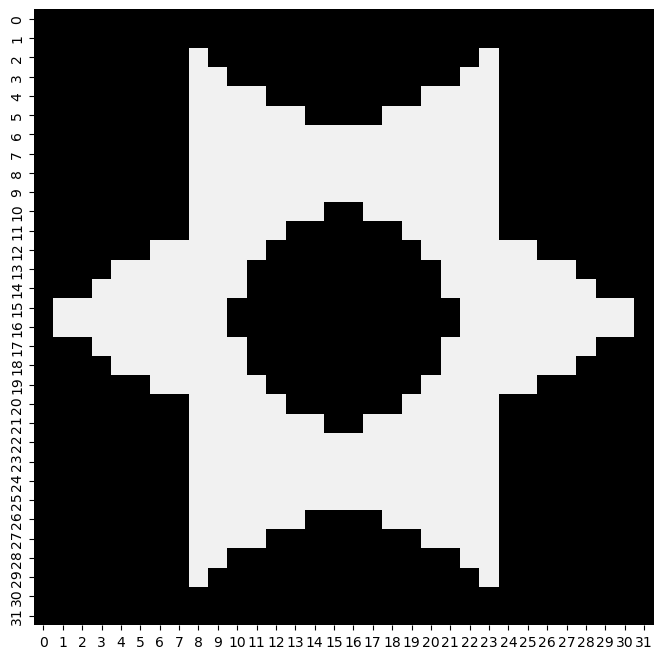

In [65]:
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt

libpath = os.environ["BENCH"] + "/DOTmark_1.0/Data/Shapes/"
c1 = pd.read_csv(libpath + "data32_1004.csv", header=None).to_numpy().astype(float)
c2 = pd.read_csv(libpath + "data32_1007.csv", header=None).to_numpy().astype(float)
# c1 = pd.read_csv(libpath + "data64_1004.csv", header=None).to_numpy()
c3 = pd.read_csv(libpath + "data32_1008.csv", header=None).to_numpy().astype(float)
c1 /= c1.max()
c2 /= c2.max()
c3 /= c3.max()
r1 = c1 / c1.sum()
r2 = c2 / c2.sum()
r3 = c3 / c3.sum()
W = np.zeros((1024, 1024))


fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.color_palette("light:k_r", as_cmap=True)
sns.heatmap(c1, cmap=cmap, cbar=False, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(c2, cmap=cmap, cbar=False, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(c3, cmap=cmap, cbar=False, ax=ax)
plt.show()


In [67]:

import torch
r1 = c1.reshape(1024)+ 1e-4
r2 = c2.reshape(1024) + 1e-4
r3 = c3.reshape(1024)  + 1e-4
r1 /= r1.sum()
r2 /= r2.sum()
r3 /= r3.sum()
def euclidean_distance(ind, h):
    ind1 = ind // (h*h)
    ind2 = ind % (h*h)
    i1 = ind1 // (h)
    j1 = ind1 % (h)
    i2 = ind2 // (h)
    j2 = ind2 % (h)
    return (i1 - i2)**2 + (j1 - j2)**2
euclidean_distance = np.vectorize(euclidean_distance)
W = euclidean_distance(np.arange(1024*1024), 32).astype(float)
W = W.reshape(1024,1024)
W /= W.max()
R = torch.tensor(np.column_stack([r1, r2, r3]), device='cuda')
rmean = ot.barycenter(R, torch.tensor(W, device='cuda'), 1e-4, verbose=True)
r1.sum()

    1|4.565163e-01|
   11|3.358252e-01|
   21|2.620895e-01|
   31|2.261246e-01|
   41|2.068594e-01|
   51|1.958545e-01|
   61|1.890528e-01|
   71|1.841996e-01|
   81|1.800458e-01|
   91|1.762093e-01|
  101|1.725774e-01|
  111|1.690789e-01|
  121|1.656319e-01|
  131|1.620966e-01|
  141|1.584784e-01|
  151|1.548793e-01|
  161|1.513769e-01|
  171|1.479964e-01|
  181|1.447421e-01|
  191|1.416370e-01|
  201|1.386761e-01|
  211|1.358480e-01|
  221|1.331579e-01|
  231|1.306111e-01|
  241|1.282069e-01|
  251|1.259484e-01|
  261|1.238304e-01|
  271|1.218398e-01|
  281|1.199294e-01|
  291|1.180651e-01|
  301|1.162387e-01|
  311|1.144621e-01|
  321|1.127484e-01|
  331|1.110818e-01|
  341|1.093997e-01|
  351|1.076066e-01|
  361|1.056543e-01|
  371|1.035419e-01|
  381|1.013713e-01|
  391|9.925179e-02|
  401|9.721739e-02|
  411|9.527437e-02|
  421|9.341852e-02|
  431|9.164428e-02|
  441|8.994550e-02|
  451|8.831689e-02|
  461|8.675539e-02|
  471|8.525965e-02|
  481|8.383014e-02|
  491|8.246928e-02|


np.float64(1.0)

<Axes: >

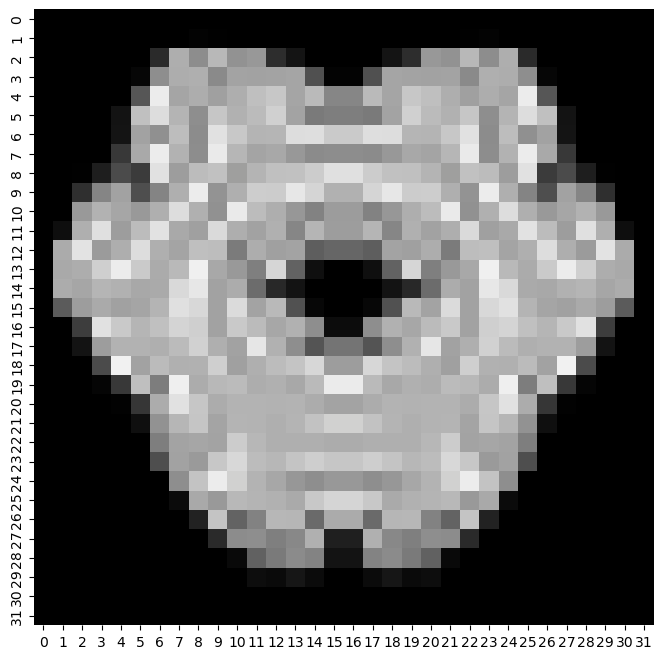

In [7]:
# rv = np.reshape(np.loadtxt("r.txt"), (64, 64)).T
# rv /= rv.max()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(rmean.cpu().reshape(32,32), cmap=cmap, cbar=False,ax=ax)


In [ ]:
rv = np.loadtxt("r32.txt")


np.float64(1.0)

In [68]:
rv = np.reshape(np.loadtxt("r32.txt"), (32, 32)).T.flatten()
emdv1 = ot.emd2(rv, r1, W) + ot.emd2(rv, r2, W) + ot.emd2(rv, r3, W)
emdv2 = ot.emd2(rmean.cpu().numpy(), r1, W) + ot.emd2(rmean.cpu().numpy(), r2, W) + ot.emd2(rmean.cpu().numpy(), r3, W)
emdv1, emdv2

(0.008267742523353643, 0.008261966207113796)

<Axes: >

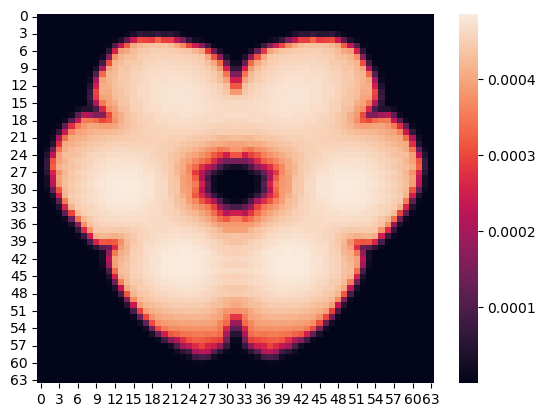

In [71]:
rv = np.reshape(np.loadtxt("r64.txt"), (64, 64)).T.flatten()

sns.heatmap(rv.reshape(64,64))

<Axes: >

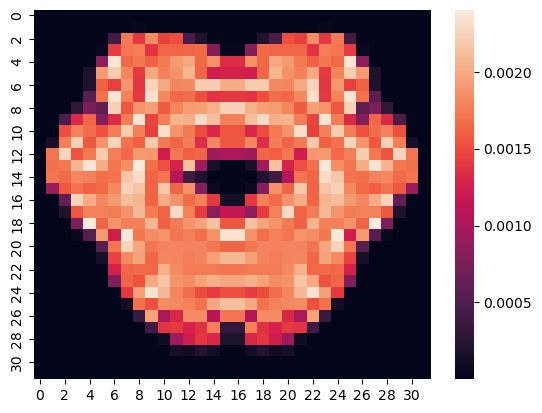

In [60]:
sns.heatmap(rv.reshape(32,32))

<Axes: >

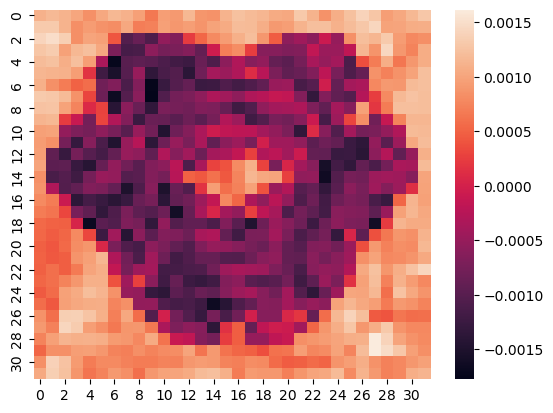

In [59]:

diff = rmean.T.cpu().numpy().reshape(1024)-rv.reshape(1024)
sns.heatmap(diff.reshape(32,32))

<Axes: >

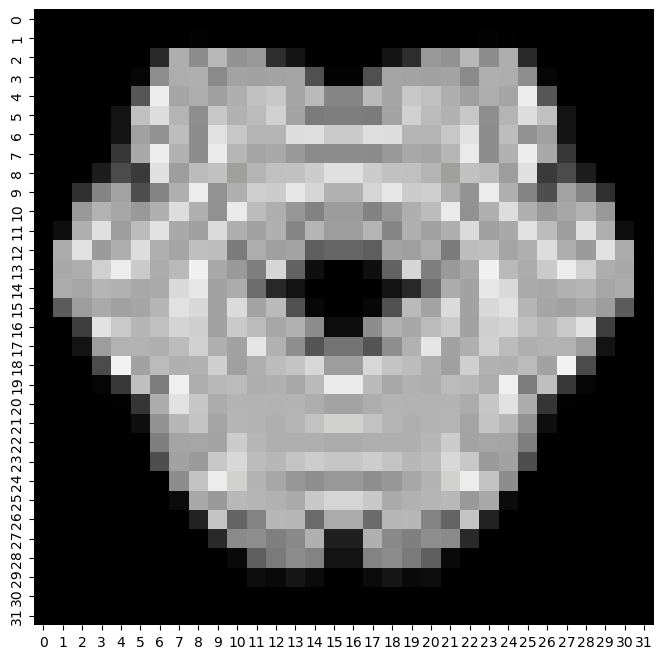

In [40]:
import seaborn as sns
cmap = sns.color_palette("light:k_r", as_cmap=True)

rv = np.reshape(np.loadtxt("r32.txt"), (32, 32)).T
rv /= rv.max()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(rv, cmap=cmap, cbar=False,ax=ax)
# for c in 

In [139]:
np.savetxt('r64.txt', rv)

In [56]:
sum([ot.emd2(r, c[:,i], W) for i in range(c.shape[1])])

tensor(0.1565, device='cuda:0', dtype=torch.float64)